In [2]:
print('py')

py


Using TensorFlow backend.


> Loading data... 
> Data Loaded. Compiling...
Train on 2121 samples, validate on 236 samples
Epoch 1/1
2121/2121 [==============================] - 20s - loss: 0.0136 - val_loss: 0.0021
Training duration (s) :  48.16362643241882


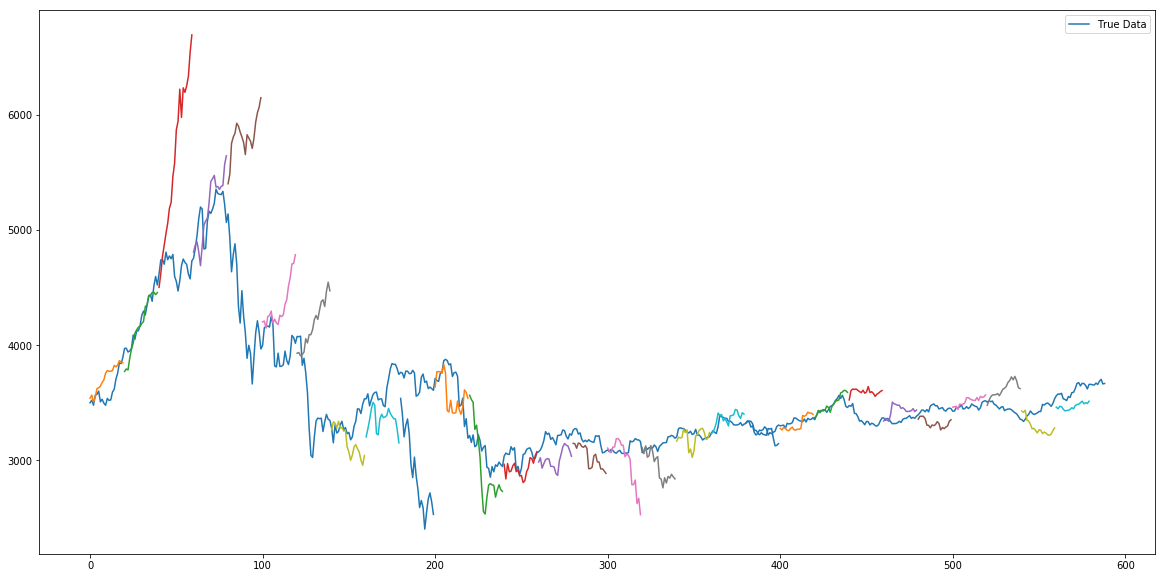

In [ ]:
class conf:
    instrument = '000300.SHA'  #股票代码
    #设置用于训练和回测的开始/结束日期
    start_date = '2005-01-01'  
    end_date='2017-07-19'
    field='close'
    seq_len=100 #每个input的长度
    prediction_len=20 #预测数据长度
    train_proportion=0.8 #训练数据占总数据量的比值，其余为测试数据
    normalise=True #数据标准化
    epochs  = 1 #LSTM神经网络迭代次数
    batch=100 #整数，指定进行梯度下降时每个batch包含的样本数,训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步
    validation_split=0.1 # 0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。
    lr=0.001 #学习效率
    

# 2. LSTM策略主体
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers


def load_data(instrument,start_date,end_date,field,seq_len,prediction_len,train_proportion,normalise=True):
    # 加载数据，数据变化，提取数据模块
    fields=[field,'amount']
    data=D.history_data(instrument,start_date,end_date,fields)
    data=data[data.amount>0]
    datetime=list(data['date'])
    data=list(data[field])
    seq_len=seq_len+1  
    result=[]
    for index in range(len(data)-seq_len):
        result.append(data[index:index+seq_len])
        
    if normalise:
        norm_result=normalise_windows(result)
    else:
        norm_result=result
        
    result=np.array(result)
    norm_result=np.array(norm_result)
    
    row=round(train_proportion*norm_result.shape[0])
    
    data_test=result[int(row):,:]
    datetime=datetime[int(row):]

    test_datetime=[]
    for index in range(len(datetime)):
        if index % prediction_len==0 and index+seq_len<len(datetime)-prediction_len:
            test_datetime.append(datetime[index+seq_len])
    
    train=norm_result[:int(row),:]
    np.random.shuffle(train)   #随机打乱训练样本
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = norm_result[int(row):, :-1]
    y_test = norm_result[int(row):, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test, data_test, test_datetime]
    
def normalise_windows(window_data):
    #数据规范化
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def denormalise_windows(normdata,data,seq_len):
    #数据反规范化
    denormalised_data = []
    wholelen=0
    for i, rowdata in enumerate(normdata):
        denormalise=list()
        if isinstance(rowdata,float)|isinstance(rowdata,np.float32):
            denormalise = [(rowdata+1)*float(data[wholelen][0])]
            denormalised_data.append(denormalise)
            wholelen=wholelen+1
        else:       
            for j in range(len(rowdata)):
                denormalise.append((float(rowdata[j])+1)*float(data[wholelen][0]))
                wholelen=wholelen+1
            denormalised_data.append(denormalise)
    return denormalised_data

def build_model(layers):
    # LSTM神经网络层
    model = Sequential()  

    model.add(LSTM(input_dim=layers[0],output_dim=layers[1],return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[1],
        return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        input_dim=layers[1],
        output_dim=layers[2]))
    model.add(Activation("linear"))

    rms=optimizers.RMSprop(lr=conf.lr, rho=0.9, epsilon=1e-06)
    model.compile(loss="mse", optimizer=rms)
    start = time.time()
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #每次只预测1步长
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, seq_len):
    #根据训练模型和第一段用来预测的时间序列长度逐步预测整个时间序列
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, seq_len, prediction_len):
    #根据训练模型和每段用来预测的时间序列长度逐步预测prediction_len长度的序列
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data):
    #做图函数，用于predict_point_by_point和predict_sequence_full
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data)
    plt.legend()
    figure=plt.gcf()
    figure.set_size_inches(20,10)
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    #做图函数，用于predict_sequences_multiple
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)    
    plt.legend()
    figure=plt.gcf()
    figure.set_size_inches(20,10)
    plt.show()

#主程序
global_start_time = time.time() 

print('> Loading data... ')

X_train,y_train,X_test,y_test,data_test,test_datetime=load_data(conf.instrument,conf.start_date,conf.end_date,conf.field,conf.seq_len,conf.prediction_len,conf.train_proportion,normalise=True)

print('> Data Loaded. Compiling...')

model = build_model([1, conf.seq_len, 1])

model.fit(
    X_train,
    y_train,
    batch_size=conf.batch,
    nb_epoch=conf.epochs,
    validation_split=conf.validation_split)


predictions = predict_point_by_point(model, X_test)  
   
if conf.normalise==True:   
    predictions=denormalise_windows(predictions,data_test,conf.seq_len)
    y_test=denormalise_windows(y_test,data_test,conf.seq_len)

print('Training duration (s) : ', time.time() - global_start_time)
plot_results(predictions, y_test)




In [10]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(Dense(32, input_shape=(500,)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

TypeError: 'Dense' object is not iterable

In [2]:
instrument = '000300.SHA'  #股票代码
    #设置用于训练和回测的开始/结束日期
start_date = '2005-01-01'  
end_date='2017-07-19'
field='close'
fields=[field,'amount']

df=D.history_data(instrument,start_date,end_date,fields)

In [4]:
index=10
seq_len=101
df[index:index+seq_len]

,close,date,instrument,amount
10,974.689026,2005-01-18,000300.SHA,4.117944e+09
11,967.210022,2005-01-19,000300.SHA,3.427951e+09
12,956.244995,2005-01-20,000300.SHA,4.399351e+09
13,982.604004,2005-01-21,000300.SHA,8.152086e+09
14,998.132996,2005-01-24,000300.SHA,8.360161e+09
15,997.775024,2005-01-25,000300.SHA,6.157022e+09
16,989.927979,2005-01-26,000300.SHA,4.719440e+09
17,974.630981,2005-01-27,000300.SHA,4.094399e+09
18,969.208984,2005-01-28,000300.SHA,3.280950e+09
19,954.879028,2005-01-31,000300.SHA,3.863574e+09


In [5]:
def normalise_windows(window_data):
    #数据规范化
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [7]:
normalise_windows([df[index:index+seq_len]])

ValueError: could not convert string to float: 'close'